In [ ]:
#<img src="Figs/GEOS_logo.pdf" width="500"/>

# Statistical testing tools for synthetic data sets: 
## <font color=blue>"stat_synthetic.ipynb"</font>
#### Feb 10, 2022  <font color=red>(v. testing)</font>
##### Jeonghyeop Kim (jeonghyeop.kim@gmail.com)

1. This code is a part of the joint inversion project (project4: joint inversion of GNSS and InSAR)

2. The followings will be plotted and saved:
- The "L-curve"
- The "heat map" as a function of relative weighting values
- The misfit of 3-D motion as a function of damping parameters

**`Note that a "true" 3-D field is only available for synthetic data sets`**


In [22]:
## Import libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
## Initialization

inversion_type='L2'  #'L1' or 'L2'
subdir_name = 'input_files' # sub directory where your input files are



cwd = os.getcwd()
path=os.path.join(cwd, subdir_name)

print("You want statistical test results for the %s inversion results." %inversion_type)
print("You saved %s_stat* & %s_model_coef* files in the following directory:" %(inversion_type,inversion_type))
print("'%s'" %path)

You want statistical test results for the L2 inversion results.
You saved L2_stat* & L2_model_coef* files in the following directory:
'/Users/jkim/main/Joint_GNSS_INSAR/statistical_testing_tools_02092022/input_files'


In [3]:
## Define ComputeModelNorm function

def ComputeModelNorm(model_arr,inversion='L2'):
    if inversion=='L2':
        norm_type=2
    else:
        norm_type=1   
    model_norm=np.linalg.norm(model_arr,norm_type)
    
    return model_norm

In [4]:
## Define MakeFileName function 

def MakeFileName(head,ext,paramList):
    
    glue = '_'
    paramList_glue = glue.join(paramList)
    filename = head + paramList_glue + ext
    
    return filename

In [5]:
## Save parameter variables from the existing files
## wI : weighting for InSAR
## wG : weighting for GNSS
## alpha : regularization param 
## beta  : 2nd regularization param (for L2 only)

load_params = []
scan_file = inversion_type+'_stat_'

if inversion_type=='L2':
    names=['wI','wG','alpha','beta']     
    with os.scandir(path) as it: #scan the directory
        for entry in it:
            if entry.name.startswith(scan_file) and entry.is_file():
                element1=entry.name.split("_")[2:][0]
                element2=entry.name.split("_")[2:][1]
                element3=entry.name.split("_")[2:][2]
                element4=entry.name.split("_")[2:][-1][0:-4] 
                # [0:-4] means without extension (e.g., .dat or .txt)
                list_elements = [element1, element2, element3, element4]
                load_params.append(list_elements)

elif inversion_type=='L1':
    names=['wI','wG','alpha']
    with os.scandir(path) as it: #scan the directory
        for entry in it:
            if entry.name.startswith(scan_file) and entry.is_file():
                element1=entry.name.split("_")[2:][0]
                element2=entry.name.split("_")[2:][1]
                element3=entry.name.split("_")[2:][-1][0:-4]
                # [0:-4] means without extension(e.g., .dat or .txt)
                list_elements = [element1, element2, element3]
                load_params.append(list_elements)        

else: #stop the code
    print(" ********************************************** ")
    print(" *                                            * ")
    print(" * inversion_type must be either 'L2' or 'L1' * ")    
    print(" *                                            * ")    
    print(" ********************************************** ")

    exit() 
    
    
df_param_string = pd.DataFrame(load_params,columns=names)
df_param_numeric = df_param_string.astype(float)

In [6]:
model_norms = []
misfits = []

for i in range(len(df_param_string)):
    paramList=df_param_string.iloc[i,:].values
    
    ## Calculate & save model norms
    head = inversion_type + '_model_coef_'
    ext = '.dat'
    filename_model=MakeFileName(head,ext,paramList)
    model_arr = np.loadtxt(path+'/'+filename_model)
    model_norm=ComputeModelNorm(model_arr,inversion=inversion_type)
    model_norms.append(model_norm)
    
    ## Save inversion misfits
    head = inversion_type + '_stat_'
    ext = '.txt'
    filename_stat=MakeFileName(head,ext,paramList)
    stat_arr = np.loadtxt(path+'/'+filename_stat)
    misfits.append(float(stat_arr))

In [7]:
df_param_numeric['model_norm']=model_norms
df_param_numeric['model_misfit']=misfits

#fixed wI, wG, beta -> vary alpha -> save norm and misfit -> L curve.
#fixed alpha and beta -> vary wl, wG -> save misfit -> heat map.

In [8]:
df_param_numeric.shape

(7044, 6)

In [9]:
pd.set_option('display.max_rows', None)

In [10]:
df_param_numeric_sorted=df_param_numeric.sort_values(by=['wI', 'wG', 'beta', 'alpha'],ignore_index=True)
#df_param_numeric_group=df_param_numeric_sorted.groupby(['wI', 'wG', 'beta'])
df_param_numeric_sorted['w_ratio']=df_param_numeric_sorted.wG.values/df_param_numeric_sorted.wI.values

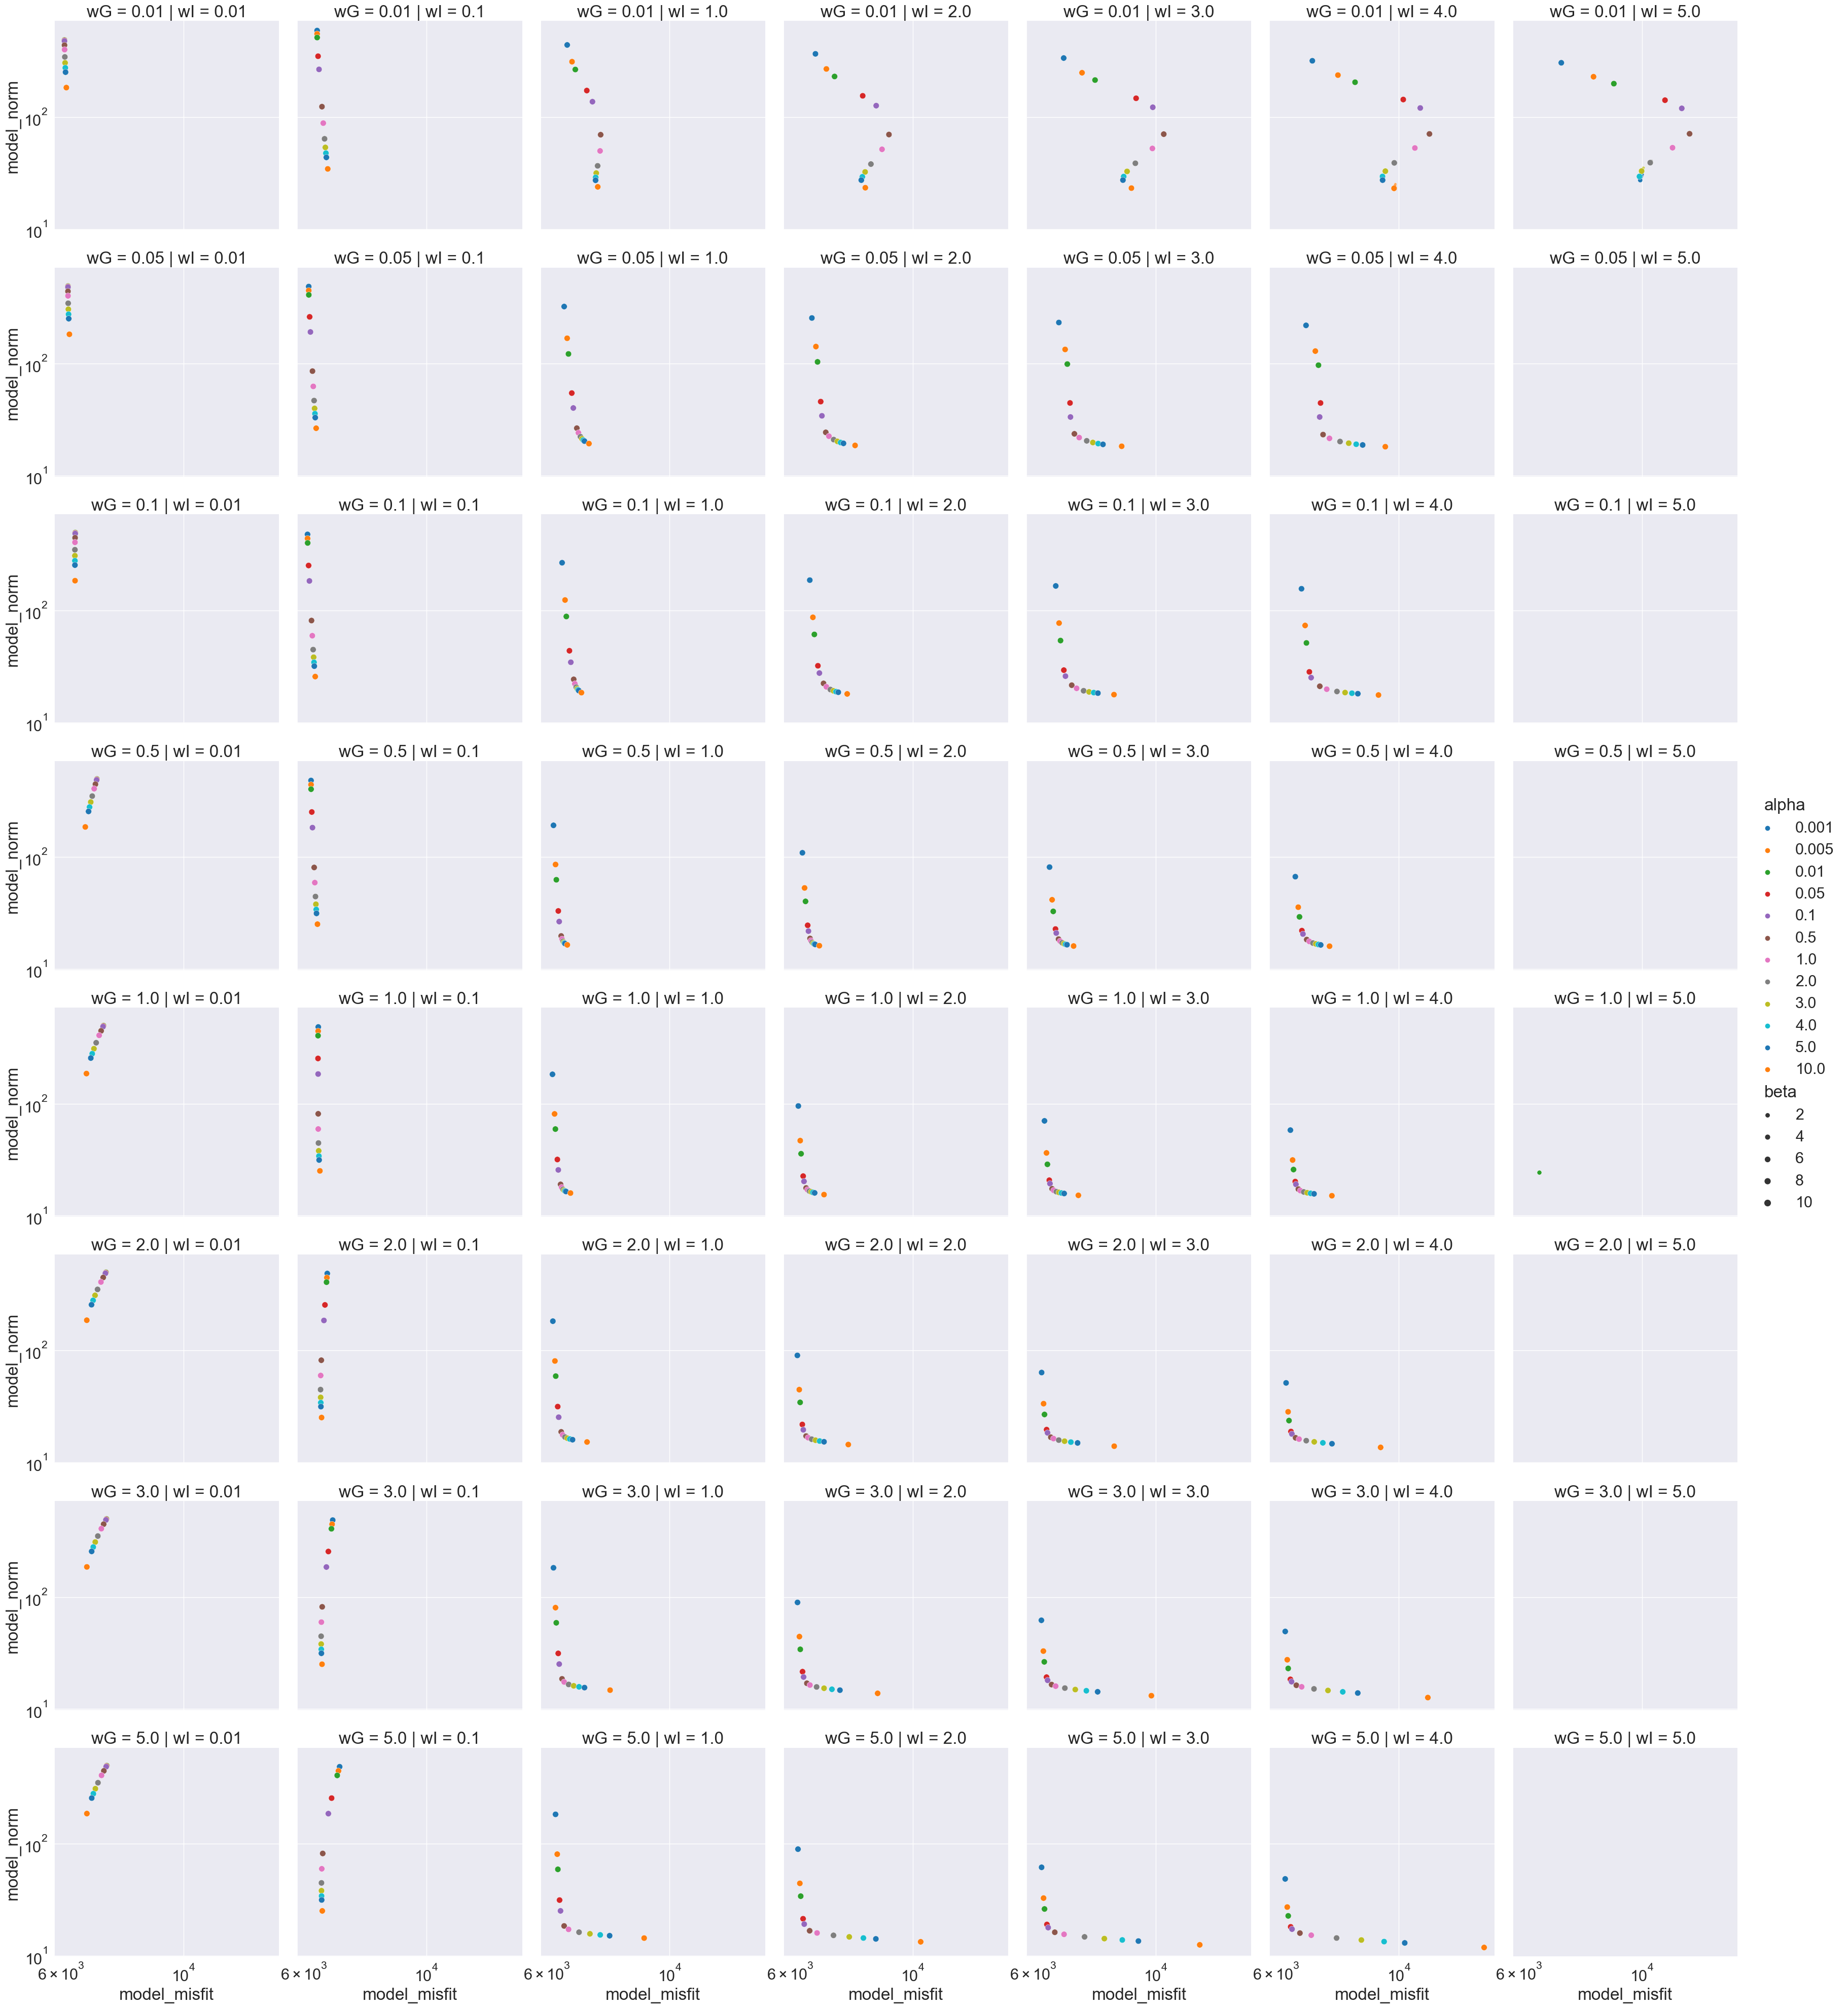

<Figure size 640x480 with 0 Axes>

In [48]:
#viz_dict={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue', 'axes.titlesize':18, 'axes.labelsize':32}

viz_dict={'axes.facecolor':'white', 'figure.facecolor':'white', 'axes.titlesize':18, 'axes.labelsize':32}
#sns.set_style("ticks")
#sns.set_style("darkgrid")
#sns.set_theme(font_scale=2, rc=viz_dict)
sns.set_theme(font_scale=2)
#matplotlib.rc_file_defaults()
sns.relplot(x="model_misfit", y="model_norm", hue="alpha", size="beta",  
             data=df_param_numeric_sorted, col="wI", row="wG", palette= "tab10")
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()
#plt.savefig("L-curve.pdf")

In [ ]:
df_wl = df_param_numeric.wI
df_wl.shape
df_wl_unique = pd.unique(df_wl)

df_wG = df_param_numeric.wG
df_wG.shape
df_wG_unique = pd.unique(df_wG)

df_beta = df_param_numeric.beta
df_beta.shape
df_beta_unique = pd.unique(df_beta)

df_alpha = df_param_numeric.alpha
df_alpha.shape
df_alpha_unique = pd.unique(df_alpha)

In [ ]:
# ## Obtain norms of the column vectors in the G matrix
# df_G=pd.read_csv(path+'/'+'G_matrix.out')
# n_col=df_G.shape[1]
# df_G.columns=[i for i in range(n_col)]
# G = df_G.to_numpy()

# amp_column=np.linalg.norm(G,axis=0) #column vectors' magnitudes

# ##normalized_model = norm_column * model

In [ ]:
#df = df.drop_duplicates(subset=['0'],keep=False)